# ANALYSIS OF REAL DATA (SRON)

From real MnKa1, MnKa2, MnKb it creates a library of optimal filters and reconstruct (and calibrate) data calculating FWHM of lines

0. Imports and definitions

1. Creation of Kas library

        1.1. Transform h5 files to FITS (using PHASE info) 
        1.2. Populate PH_ID column with row (record) number
        1.3. Select records with Ka1 and Ka2 lines (by limiting the Pulse height)
        1.4. Create a library with this new file with Kas lines

2. Creation of Ka2 library

    2.1 Reconstruct Kas data with initial library
    
    2.2 Select only Ka2 pulses not in multiple-pulse records (from R script)
    
        2.2.0 Find/identify multiple-pulse records
        2.2.1 Read data from HR Kas evt file to identify Ka1 and Ka2
        2.2.2 Fit a double Gaussian to select Ka2 pulses
        2.2.3 Select PH_ID of (non)Ka2 pulses
        2.2.4 Extract Ka2 pulses to build the new library
        
    2.3 Build the new library of Ka2 pulses
 
3. Reconstruct all pulses with new Ka2 library

4. Calibrate data fitting 2 Gaussians (Kas) + 1 Gaussian (Kb)

        4.1 Read HR pulses
        4.2 Fit 2 gaussians to Kas and 1 gaussian to Kb
        4.3 Create gain scale
        4.4 Calibrate energies
        
        
5. Get FWHM of Kas lines fitting Voigt profiles

6. Jitter correction

    6.1 Plot recon PH vs PHASE (PHI+LAGS) & Fit a polynomial
    
    6.2 Fit gaussians, create new Gain scale and re-calibrate energies
    
    6.3 Fit histogram of jitter-corrected energies
    
7. baseline drift correction

    7.1 Plot jiterr_recon PH vs Baseline & Fit polynomial
    
    7.2 Fit gaussians, create new Gain scale and re-calibrate energies
    
    7.3 Fit histogram of baseline-jitter-corrected energies
        

## 0) Imports and definitions

In [16]:
from subprocess import check_call, check_output,STDOUT
from astropy.io import fits
from scipy.stats import norm
from scipy.optimize import curve_fit
from statistics import mean
import math
import sys, os
import shutil, tempfile, shlex
import numpy as np
import numpy.polynomial.polynomial as poly
import auxpy
import matplotlib.pyplot as plt
from datetime import datetime
import pandas
from astropy.modeling import models, fitting

cwd = os.getcwd()
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"

In [17]:
# data files
fileNum = "2"
noiseNum = "2"
resDir = "file" + str(fileNum) + "noise" + str(noiseNum)
if not os.path.exists(resDir):
    os.makedirs(resDir)
ratio = 5 # ratio Ka2_gaussProb/Ka1_gaussProb
file0ph = "file" + fileNum + "ph.fits"   # initial file with all records
fileph  = "file" + fileNum + "ph_phid.fits" # initial file with all records and PH_ID column populated
fileph_Kas = "file" + fileNum + "ph_phid_Kas.fits" # data file with only those records with Kas lines
noisefile = "noise" + noiseNum + "ph_8192_noisespec.fits"

In [18]:
PHmin = 159000 # ADC units to limit Kas lines
PHmax = 161000 
Ka1keV = 5.88765 # keV Ka1
Ka2keV = 5.89875 # keV Ka2
KbkeV = 6.49045  # keV Kb
Ka1eV = Ka1keV * 1000. # eV for Ka1
Ka2eV = Ka2keV * 1000. # eV for Ka2
KbeV = KbkeV * 1000.   # eV for Kb

In [19]:
# library Kas creation
plen = 8192
oflen = 8192
preBuffer = 0
method = "OPTFILT"
F0orB0 = "F0"
nS = 5
sU = 3
sD = 4
KaseV = 5895 # eV reference energy: 8.2%*5.88765(Ka1)+16.2%*5.89875(Ka2)
libKas = resDir + "/" + "library_Kas_" + str(plen) + ".fits"

In [20]:
# reconstructed files
evtKas_libKas = resDir + "/" + "evt_file" + fileNum + "phKas_lib" + noiseNum + "file" + fileNum + "phKas_" + method + str(oflen) + ".fits"
evtKas_libKas_HR = resDir + "/" + "evt_file" + fileNum + "phKas_lib" + noiseNum + "file" + fileNum + "phKas_" + method + str(oflen) + "_HR.fits"
evtKas_libKa2 = resDir + "/" + "evt_file" + fileNum + "phKas_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + ".fits"
evtKas_libKa2_HR = resDir + "/" + "evt_file" + fileNum + "phKas_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + "_HR.fits"
evt_libKa2 = resDir + "/" + "evt_file" + fileNum + "ph_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + ".fits"
evt_libKa2_HR = resDir + "/" + "evt_file" + fileNum + "ph_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + "_HR.fits"
evt_libKa2_abs = resDir + "/" + "evtabs_file" + fileNum + "ph_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + ".fits"
evt_libKa2_abs_HR = resDir + "/" + "evtabs_file" + fileNum + "ph_lib" + noiseNum + "file" + fileNum + "phKa2_" + method + str(oflen) + "_HR.fits"

In [21]:
# library Ka2 creation
fileph_Ka2 = resDir + "/" + "file_Ka2.fits" # data file with only those single records with Ka2 lines
libKa2 = resDir + "/" + "library_Ka2_ratio" + str(ratio) + "_" + str(plen) + ".fits"

In [22]:
def fit2GaussAndRatio(data=None, a1=50, a2=90, mean1=5.8, mean2=5.9, sig1=0.005, sig2=0.005, nbins1=200, xlab=None):

    """"
    
    Fit 2 Gaussians (Ka1, Ka2) to Kas histogram 
    Histograms are created and plotted with matplotlib.pyplot.hist in Density
    Gaussians functions from astropy.fitting module (fitting by LevMarLSQFitter)
    
    data1: (array) data for 1st histogram
    a1: (float) initial amplitude for Gaussian1
    a2: (float)initial amplitude for Gaussian2
    mean1: (float)initial mean for Gaussian1
    mean2: (float)initial mean for Gaussian2
    sig1: (float)std dev for Gaussian1
    sig2: (float)std dev for Gaussian2
    nbins1: number of bins for first (Kas) histogram
    
    """
    fig = plt.figure(figsize=(16,6))
    ax1 = fig.add_subplot(1, 2, 1)

    # create histogram
    bin_heights, bin_borders, _ = ax1.hist(data, bins=nbins1, density=True,label="Histogram", alpha=0.5)
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

    # fit two gaussians to density-histogram (also "curve_fit" ?)
    gg_init = (models.Gaussian1D(amplitude=a1, mean=mean1, stddev=sig1) +
               models.Gaussian1D(amplitude=a2, mean=mean2, stddev=sig2))
    #fitter = fitting.SLSQPLSQFitter()
    fitter = fitting.LevMarLSQFitter()
    gg_fit = fitter(gg_init, bin_centers, bin_heights)
    print("Message (Kas)=", fitter.fit_info['message'])

    #C1 = gg_fit.param_sets[0][0]
    #mean1 = gg_fit.param_sets[1][0] #u.a.
    #sigma1 = gg_fit.param_sets[2][0] #u.a.
    #C2 = gg_fit.param_sets[3][0] 
    #mean2 = gg_fit.param_sets[4][0] #u.a.
    #sigma2 = gg_fit.param_sets[5][0] #u.a.

    C1 = gg_fit.amplitude_0[0]
    mean1 = gg_fit.mean_0[0]
    sigma1 = gg_fit.stddev_0[0]
    fwhm1 = sigma1 *1000.* 2*np.sqrt(2*np.log(2)) #mu.a.
    C2 = gg_fit.amplitude_1[0]
    mean2 = gg_fit.mean_1[0]
    sigma2 = gg_fit.stddev_1[0]
    fwhm2 = sigma2 * 1000. * 2*np.sqrt(2*np.log(2)) #mu.a.
    #gg_fit.fit_info['residuals']
    g1 = models.Gaussian1D(amplitude=C1, mean=mean1, stddev=sigma1)
    g2 = models.Gaussian1D(amplitude=C2, mean=mean2, stddev=sigma2)
    ratioGG = g2(x_interval_for_fit)/g1(x_interval_for_fit)
    #print("minGG=",min(ratioGG), "maxGG=",max(ratioGG))

    # plot histogram and Gaussians fit
    ax1.plot(x_interval_for_fit, gg_fit(x_interval_for_fit), label='Gauss fit')
    ax1.plot(x_interval_for_fit, g1(x_interval_for_fit), label="Gauss Ka1")
    ax1.plot(x_interval_for_fit, g2(x_interval_for_fit), label="Gauss Ka2")
    ax1.plot(x_interval_for_fit, ratioGG, label="ratio G2/G1")
    ax1.axhline(ratio,linestyle='--', color='tab:purple')
    maxy = max(bin_heights)
    ax1.text(5.87,maxy, "Double Gaussian", color='tab:orange')
    ax1.text(5.87,maxy-10, "Mean(Ka1)=" + '{:0.3f}'.format(mean1) + "a.u", color='tab:green')
    ax1.text(5.87,maxy-20, "FWHM(Ka1)=" + '{:0.3f}'.format(fwhm1) + "ma.u", color='tab:green')
    ax1.text(5.87,maxy-30, "Mean(Ka2)=" + '{:0.3f}'.format(mean2) + "a.u", color='tab:red')
    ax1.text(5.87,maxy-40, "FWHM(Ka2)=" + '{:0.3f}'.format(fwhm2) + "ma.u", color='tab:red')
    ax1.set_xlabel(xlab)
    ax1.set_ylabel("Density")
    ax1.set_xlim(5.86, 5.94)
    ax1.set_ylim(0, 130)
    plt.legend()
    plt.show()
    PHmin = x_interval_for_fit[ratioGG >= ratio][0]
    PHmax = min(x_interval_for_fit[ratioGG >= ratio][-1], (mean2+10*sigma2))
    print("Ka2 PHs in [" + '{:0.3f}'.format(PHmin) + "," + '{:0.3f}'.format(PHmax) + "] a.u.")
    return((PHmin,PHmax))

In [85]:
def fit3gauss2hist(data1=None, data2=None, a1=50, a2=90, a3=50, mean1=5.8, mean2=5.9, mean3=6.5, 
                   sig1=0.005, sig2=0.005, sig3=0.005, nbins1=200, nbins2=200, plot=True):
    """"
    
    Fit 2 Gaussians (Ka1, Ka2) to Kas histogram and 1 Gaussian to Kb histogram
    Histograms are created and plotted with matplotlib.pyplot.hist in Density
    Gaussians functions from astropy.fitting module (fitting by LevMarLSQFitter)
    
    data1: (array) data for 1st histogram
    data2: (array) data for 2st histogram
    a1: (float) initial amplitude for Gaussian1
    a2: (float)initial amplitude for Gaussian2
    a3: (float)initial amplitude for Gaussian3
    mean1: (float)initial mean for Gaussian1
    mean2: (float)initial mean for Gaussian2
    mean3: (float)initial mean for Gaussian3
    sig1: (float)std dev for Gaussian1
    sig2: (float)std dev for Gaussian2
    sig3: (float)std dev for Gaussian3
    nbins1: number of bins for first (Kas) histogram
    nbins2: number of bins for second (Kb) histogram
    
    """
    fig = plt.figure(figsize=(20,6))
    ax1 = fig.add_subplot(1, 2, 1)
    
    # create histogram
    bin_heights, bin_borders, _ = ax1.hist(data1,bins=nbins1, density=True,label="Histogram", alpha=0.5)
    if not plot:
        plt.clf()
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

    # fit two gaussians to density-histogram (also "curve_fit" ?)
    gg_init = (models.Gaussian1D(amplitude=a1, mean=mean1, stddev=sig1) + 
               models.Gaussian1D(amplitude=a2, mean=mean2, stddev=sig2))
    #fitter = fitting.SLSQPLSQFitter()
    #fitter = fitting.LinearLSQFitter() -> model is not linear in parameters: linear fit should not be used
    fitter = fitting.LevMarLSQFitter()
    gg_fit = fitter(gg_init, bin_centers, bin_heights,maxiter=300)
    print("Message (Kas)=", fitter.fit_info['message'])
    print("Param_cov (Kas)=", fitter.fit_info['param_cov'])
    
    C1 = gg_fit.amplitude_0[0]
    mean1 = gg_fit.mean_0[0]
    sigma1 = gg_fit.stddev_0[0]
    fwhm1 = sigma1 *1000.* 2*np.sqrt(2*np.log(2)) #mu.a.
    C2 = gg_fit.amplitude_1[0]
    mean2 = gg_fit.mean_1[0]
    sigma2 = gg_fit.stddev_1[0]
    fwhm2 = sigma2 * 1000. * 2*np.sqrt(2*np.log(2)) #mu.a.
    g1 = models.Gaussian1D(amplitude=C1, mean=mean1, stddev=sigma1)
    g2 = models.Gaussian1D(amplitude=C2, mean=mean2, stddev=sigma2)

    if plot:
        # plot 1st histogram and 2 Gaussians fit
        ax1.plot(x_interval_for_fit, gg_fit(x_interval_for_fit), label='Gauss fit')
        ax1.plot(x_interval_for_fit, g1(x_interval_for_fit), label="Gauss Ka1")
        ax1.plot(x_interval_for_fit, g2(x_interval_for_fit), label="Gauss Ka2")
        maxy = max(bin_heights)
        xtxt = min(data1)+0.001
        ax1.text(xtxt,maxy, "Double Gaussian", color='tab:orange')
        ax1.text(xtxt,maxy-10, "Mean(Ka1)=" + '{:0.3f}'.format(mean1) + "a.u", color='tab:green')
        ax1.text(xtxt,maxy-20, "FWHM(Ka1)=" + '{:0.3f}'.format(fwhm1) + "ma.u", color='tab:green')
        ax1.text(xtxt,maxy-30, "Mean(Ka2)=" + '{:0.3f}'.format(mean2) + "a.u", color='tab:red')
        ax1.text(xtxt,maxy-40, "FWHM(Ka2)=" + '{:0.3f}'.format(fwhm2) + "ma.u", color='tab:red')
        ax1.set_xlabel("Reconstructed PH")
        ax1.set_ylabel("Density")
        ax1.set_xlim(min(data1), max(data1))
        ax1.legend()

    ax2 = fig.add_subplot(1, 2, 2)
        
    # create 2nd histogram
    bin_heights, bin_borders, _ = ax2.hist(data2,bins=nbins2, density=True,label="Histogram", alpha=0.5)
    if not plot:
        plt.clf()
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
    # fit 1 gaussian to density-histogram (also "curve_fit" ?)
    g_init = models.Gaussian1D(amplitude=a3, mean=mean3, stddev=sig3) 
    fitter = fitting.LevMarLSQFitter()
    g_fit = fitter(g_init, bin_centers, bin_heights)
    print("Message (Kb)=", fitter.fit_info['message'])

    C3 = g_fit.amplitude[0]
    mean3 = g_fit.mean[0]
    sigma3 = g_fit.stddev[0]
    fwhm3 = sigma3 *1000.* 2*np.sqrt(2*np.log(2)) #mu.a.

    if plot:
        # plot histogram and Gaussians fit
        ax2.plot(x_interval_for_fit, g_fit(x_interval_for_fit), label='Gauss fit')
        maxy = max(bin_heights)
        ax2.text(6.175,maxy, "Mean(Kb)=" + '{:0.3f}'.format(mean3) + "a.u", color='tab:orange')
        ax2.text(6.175,maxy-10, "FWHM(Kb)=" + '{:0.3f}'.format(fwhm3) + "ma.u", color='tab:orange')
        ax2.set_xlabel("Reconstructed PH")
        ax2.set_ylabel("Density")
        ax2.set_xlim(6.15, 6.35)
        ax2.legend()
    return((mean1,mean2,mean3))
    

In [26]:
def fit3Voigt2hist(data1=None, data2=None, a1=50, a2=90, a3=50, x0_1=5.8, x0_2=5.9, x0_3=6.5, 
                   fwhm_L1=0.005, fwhm_L2=0.005, fwhm_L3=0.005, fwhm_G1=0.005, fwhm_G2=0.005, 
                   fwhm_G3=0.005, nbins1=200, nbins2=200):
    """
    
    Fit 2 Voigt (Ka1, Ka2) to Kas histogram and 1 Voigt to Kb histogram
    Histograms are created and plotted with matplotlib.pyplot.hist in Density
    Voigt functions from astropy.fitting module (fitting by LevMarLSQFitter)
    
    data1: (array) data for 1st histogram
    data2: (array) data for 2st histogram
    a1: (float) initial amplitude for Voigt1
    a2: (float)initial amplitude for Voigt2
    a3: (float)initial amplitude for Voigt3
    x0_1: (float)initial center for Voigt1
    x0_2: (float)initial center for Voigt2
    x0_3: (float)initial center for Voigt3
    fwhm_L1: (float) FWHM for Lorentzian 1
    fwhm_L2: (float) FWHM for Lorentzian 2
    fwhm_L3: (float) FWHM for Lorentzian 3
    fwhm_G1: (float) FWHM for Gaussian1
    fwhm_G2: (float) FWHM for Gaussian2
    fwhm_G3: (float) FWHM for Gaussian3
    nbins1: number of bins for first (Kas) histogram
    nbins2: number of bins for second (Kb) histogram
    
    """
    fig = plt.figure(figsize=(20,6))
    ax1 = fig.add_subplot(1, 2, 1)

    # create histogram
    bin_heights, bin_borders, _ = ax1.hist(data1,bins=nbins1, density=True,label="Histogram", alpha=0.5)
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

    # fit two Voigts to density-histogram (also "curve_fit" ?)
    vKa11 = models.Voigt1D(x_0=x0_2, amplitude_L=a2, fwhm_L=fwhm_L2, fwhm_G=fwhm_G2)
    vKa12 = models.Voigt1D(x_0=x0_1, amplitude_L=a1, fwhm_L=fwhm_L1, fwhm_G=fwhm_G1)
    vKa13 = models.Voigt1D(x_0=x0_1, amplitude_L=a1, fwhm_L=fwhm_L1, fwhm_G=fwhm_G1)
    vKa14 = models.Voigt1D(x_0=x0_1, amplitude_L=a1, fwhm_L=fwhm_L1, fwhm_G=fwhm_G1)
    
    vKa21 = models.Voigt1D(x_0=x0_1, amplitude_L=a1, fwhm_L=fwhm_L1, fwhm_G=fwhm_G1)
    vKa22 = models.Voigt1D(x_0=x0_1, amplitude_L=a1, fwhm_L=fwhm_L1, fwhm_G=fwhm_G1)
    vKa23 = models.Voigt1D(x_0=x0_1, amplitude_L=a1, fwhm_L=fwhm_L1, fwhm_G=fwhm_G1)
    vKa24 = models.Voigt1D(x_0=x0_1, amplitude_L=a1, fwhm_L=fwhm_L1, fwhm_G=fwhm_G1)
    
    vv_init = (v1 + v2 + v3 + v4 + v5 + v6 ) 
    fitter = fitting.LevMarLSQFitter()
    vv_fit = fitter(vv_init, bin_centers, bin_heights)
    print("Message (Kas)=", fitter.fit_info['message'])
    print("Param_cov (Kas)=", fitter.fit_info)
    
    amp1 = vv_fit.amplitude_L_0[0]
    center1 = vv_fit.x_0_0[0]
    fwhm_L1 = vv_fit.fwhm_L_0[0]
    fwhm_G1 = vv_fit.fwhm_G_0[0]
    amp2 = vv_fit.amplitude_L_1[0]
    center2 = vv_fit.x_0_1[0]
    fwhm_L2 = vv_fit.fwhm_L_1[0]
    fwhm_G2 = vv_fit.fwhm_G_1[0]

    v1 = models.Voigt1D(x_0=center1, amplitude_L=amp1, fwhm_L=fwhm_L1, fwhm_G=fwhm_G1) 
    v2 = models.Voigt1D(x_0=center2, amplitude_L=amp2, fwhm_L=fwhm_L2, fwhm_G=fwhm_G2) 

    # plot histogram and 2 Voigt fit
    ax1.plot(x_interval_for_fit, vv_fit(x_interval_for_fit), label='Voigt fit')
    ax1.plot(x_interval_for_fit, v1(x_interval_for_fit), label="Voigt Ka1")
    ax1.plot(x_interval_for_fit, v2(x_interval_for_fit), label="Voigt Ka2")
    maxy = max(bin_heights)
    ax1.text(5.86,maxy, "Double Voigt", color='tab:orange')
    ax1.text(5.86,maxy-5, "Mean(Ka1)=" + '{:0.3f}'.format(center1) + "keV", color='tab:green')
    ax1.text(5.86,maxy-10, "FWHM_L(Ka1)=" + '{:0.3f}'.format(fwhm_L1*1e3) + "eV", color='tab:green')
    ax1.text(5.86,maxy-15, "FWHM_G(Ka1)=" + '{:0.3f}'.format(fwhm_G1*1e3) + "eV", color='tab:green')
    ax1.text(5.86,maxy-20, "Mean(Ka2)=" + '{:0.3f}'.format(center2) + "keV", color='tab:red')
    ax1.text(5.86,maxy-25, "FWHM_L(Ka2)=" + '{:0.3f}'.format(fwhm_L2*1e3) + "eV", color='tab:red')
    ax1.text(5.86,maxy-30, "FWHM_G(Ka2)=" + '{:0.3f}'.format(fwhm_G2*1e3) + "eV", color='tab:red')
    ax1.axvline(Ka1keV,linestyle='--', color='gray')
    ax1.axvline(Ka2keV,linestyle='--', color='gray')
    ax1.set_xlabel("Energy (keV)")
    ax1.set_ylabel("Density")
    ax1.set_xlim(5.85, 5.94)
    ax1.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    
    # create histogram
    bin_heights, bin_borders, _ = ax2.hist(data2, bins=nbins2, density=True,label="Histogram", alpha=0.5)
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)

    # fit 1 Voigt to density-histogram (also "curve_fit" ?)
    v_init = models.Voigt1D(x_0=x0_3, amplitude_L=a3, fwhm_L=fwhm_L3, fwhm_G=fwhm_G3) 
    fitter = fitting.LevMarLSQFitter()
    v_fit = fitter(v_init, bin_centers, bin_heights)
    print("Message (Kb)=", fitter.fit_info['message'])

    amp3 = v_fit.amplitude_L[0]
    center3 = v_fit.x_0[0]
    fwhm_L3 = v_fit.fwhm_L[0]
    fwhm_G3 = v_fit.fwhm_G[0]
    ax2.axvline(KbkeV,linestyle='--', color='gray')

    # plot histogram and Voigt fit
    ax2.plot(x_interval_for_fit, v_fit(x_interval_for_fit), label='Voigt fit',color='tab:orange')
    maxy = max(bin_heights)
    ax2.text(6.4,maxy, "Center(Kb)=" + '{:0.3f}'.format(center3) + "keV", color='tab:orange')
    ax2.text(6.4,maxy-5, "FWHM_L(Kb)=" + '{:0.3f}'.format(fwhm_L3*1e3) + "eV", color='tab:orange')
    ax2.text(6.4,maxy-10, "FWHM_G(Kb)=" + '{:0.3f}'.format(fwhm_G3*1e3) + "eV", color='tab:orange')
    ax2.set_xlabel("Energy (keV)")
    ax2.set_ylabel("Density")
    ax2.set_xlim(6.35, 6.6)
    ax2.legend()

In [27]:
def gainScaleFit(xData=None, yData=None):
    """
    Fit a linear model to the 3 K lines and return slope and intercept
    
    xData: (array) x data
    yData: (array) y data
    return: slope, intercept
    """
    
    """
    # fit polynomial
    coefs = poly.polyfit(x=recon_lines, y=lines, deg=2) 
    ffit = poly.polyval(x_interval_for_fit, coefs)
    """

    # define a model for a line; initialize a linear model
    line_init = models.Linear1D()
    # initialize a linear fitter
    fitter = fitting.LinearLSQFitter()
    # fit the data with the fitter
    fitted_line = fitter(line_init, xData, yData)
    print(fitted_line)
    print("Residuals=",fitter.fit_info['residuals'])
    print("Params=",fitter.fit_info['params'])
    slope = fitted_line.slope[0]
    inter = fitted_line.intercept[0]
    # check R²
    absError = fitted_line(xData) - yData
    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(yData))
    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)

    # plot the model
    fig = plt.figure(figsize=(16,6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(xData, yData, 'ko', label='Data')
    ax1.plot(xData, fitted_line(xData), 'k-', label='Fitted Model', color="red")
    ax1.set_xlabel('reconstructed lines (a.u.)')
    ax1.set_ylabel('Lines energies (keV)')
    ax1.set_xlim(xData[0]-0.01,xData[1]+0.01)
    ax1.set_ylim(yData[0]-0.01,yData[1]+0.01)
    ax1.legend()
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(xData, yData, 'ko', label='Data')
    ax2.plot(xData, fitted_line(xData), 'k-', label='Fitted Model', color="red")
    ax2.set_xlabel('reconstructed lines (a.u.)')
    ax2.set_ylabel('Lines energies (keV)')
    ax2.legend()
    
    return (slope, inter)

In [28]:
def jitterCorr(reconPH=None, phase=None):
    
    """
    Calculate jitter correction: dependance of recons PH vs Phase 
    Fit a polynomial (deg 2) and subtract effect
    Return: reconstructed PH with jitter removed
    
    reconPH: (array) reconstructed PH 
    phase1: (array) phase information 
    
    """
    
    # plot phases
    fig = plt.figure(figsize=(20,6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.scatter(phase, reconPH, marker="o")
    # fit polynomial
    x_interval_for_fit = np.linspace(min(phase), max(phase), 10000)
    ##poly1 = np.poly1d(np.polyfit(phaseKas_HR, enerKas_HR, 2))
    coefs = poly.polyfit(x=phase, y=reconPH, deg=2) # recommended instead of np.polyfit + np.poly1d
    ffit = poly.polyval(x_interval_for_fit, coefs)
    ax1.plot(x_interval_for_fit, ffit,'-', color="red")
    ax1.set_xlabel("Phase (samples)")
    ax1.set_ylabel("PH Kas (a.u.)")
    print("Fit Kas=",'{:0.3f}'.format(coefs[0]) + "+ (" + '{:0.3f}'.format(coefs[1]) + ")*x" + "+(" + '{:0.3f}'.format(coefs[2]) + ")*x²" )
    # subtract polynomial (flat jitter effect)
    ax2 = fig.add_subplot(1, 2, 2)
    reconPH_jitter = reconPH - coefs[1]*phase - coefs[2]*phase**2
    ax2.scatter(phase, reconPH_jitter, marker="o")
    ax2.set_xlabel("Phase (samples)")
    ax2.set_ylabel("Corrected PH Kas (a.u.)")
    coefsJ = poly.polyfit(x=phase, y=reconPH_jitter, deg=2)
    print("Fit Kas (corrected)=",'{:0.3f}'.format(coefsJ[0]) + "+ (" + '{:0.3f}'.format(coefsJ[1]) + ")*x" + "+(" + '{:0.3f}'.format(coefsJ[2]) + ")*x²" )
    ffitJ = poly.polyval(x_interval_for_fit, coefsJ)
    ax2.plot(x_interval_for_fit, ffitJ,'-', color="white")
    print("acabo")
    return(reconPH_jitter)

## 1) Creation of Kas library
### 1.1 Transform h5 files to FITS (using PHASE)

### 1.2 Populate PH_ID column with row (record) number
The idea is to be able to later identify which records contains pulses with the appropriate energy to build the library

In [29]:
run = False
if run:
    comm =  ("fcalc infile=" + file0ph + "+8 outfile=" + fileph + " clname=PH_ID expr='#ROW'")
    try:
        print("Populating PH_ID column")
        #print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error populating PH_ID column with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

### 1.3 Select records with Ka1 and Ka2 lines (by limiting the Pulse height)

In [30]:
run = False
if run:
    comm = ("fselect  infile=" + fileph + "+8 outfile=" + fileph_Kas + " expr='max(ADC)>" + str(PHmin) + " && max(ADC)<" + str(PHmax) +"'")
    try:
        print("Selecting Kas by Pulse Height")
        #print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Selecting Kas by Pulse Height with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

### 1.4 Create a library with this new file with Kas lines

In [31]:
run = False
if run:
    tmpFile = resDir + "/" + "pp" + str(int(datetime.timestamp(datetime.now()))) + ".fits"
    comm = ("tesreconstruction Recordfile=" + fileph_Kas + " TesEventFile=" + tmpFile + " Rcmethod='SIRENA'" +
            " PulseLength=" + str(plen) + " LibraryFile=" + libKas + " scaleFactor=0 samplesUp=" + str(sU) +
            " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=0 OFLib=yes FilterDomain=F " + 
            " detectionMode=STC detectSP=1 FilterMethod=" + F0orB0 + " clobber=yes EventListSize=1000" + 
            " EnergyMethod=" + method + " LagsOrNot=1 tstartPulse1=0 tstartPulse2=0 OFNoise=NSD " + 
            " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
            " filtEeV=" + str(KaseV) + " OFStrategy=FIXED OFLength=" + str(oflen) + " NoiseFile=" + noisefile +
            " monoenergy=" + str(KaseV) + " preBuffer=" + str(preBuffer))
    try:
        print("Building initial library (Kas)")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Building initial library (Kas) with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise
    os.remove(tmpFile)

## 2. Creation of Ka2 library

### 2.1 Reconstruct real data with initial library

In [32]:
run = False
if run:
    comm = ("tesreconstruction Recordfile=" + fileph_Kas + " TesEventFile=" + evtKas_libKas + " Rcmethod='SIRENA'" +
            " PulseLength=" + str(plen) + " LibraryFile=" + libKas + " scaleFactor=0 samplesUp=" + str(sU) +
            " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=1 OFLib=yes FilterDomain=F detectionMode=STC" +
            " detectSP=1 FilterMethod=F0 clobber=yes EnergyMethod=" + method + " LagsOrNot=1 " +
            " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
            " filtEeV=" + str(KaseV) + " OFStrategy=FIXED OFLength=" + str(oflen) + " preBuffer=" + str(preBuffer))
    try:
        print("Reconstructing real data w/ initial library (Kas)")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Reconstructing real data w/ initial library (Kas) with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

    # Select only HR events
    comm = ("fselect  infile=" + evtKas_libKas + " outfile=" + evtKas_libKas_HR + " expr='GRADE1 == " + str(plen) + 
           " && GRADE2 == " + str(plen) + "'")
    try:
        print("Selecting HR Kas evts")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Selecting HR Kas evts with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

### 2.2 Select only Ka2 pulses not in multiple-pulse records 

#### 2.2.0 Find/identify multiple-pulse records

In [33]:
# dump records info
colname = "'SIGNAL, PH_ID, GRADE1, GRADE2'" 
comm = ("fdump wrap=yes infile=" + evtKas_libKas + "+1 columns=" + colname + " rows='-' prhead=no " +
        "showcol=yes showunit=no showrow=no outfile=pulse.txt clobber=yes")
try:
    print("FDUMPing evt file")
    #print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error FDUMPing evt file with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
    
# find single records
dataKas = pandas.read_csv("pulse.txt", skiprows=0, sep="\s+")
n_ocurr = dataKas.PH_ID.value_counts() # number of ocurrences of each PH_ID
dataKas_single_PH_ID = list()
for key in sorted(n_ocurr.keys()):
    if n_ocurr[key] == 1:
        #print("Single record for PH_ID=", key)
        dataKas_single_PH_ID.append(key)

os.remove("pulse.txt")
#print("Single records in ",fileph_Kas, "=", dataKas_single_PH_ID)
print("Number of Kas records in",fileph_Kas, "=", len(dataKas))
print("Number of Single Kas records in",fileph_Kas, "=", len(dataKas_single_PH_ID))

FDUMPing evt file
Number of Kas records in file2ph_phid_Kas.fits = 13082
Number of Single Kas records in file2ph_phid_Kas.fits = 11280


#### 2.2.1 Read data from HR Kas evt file to identify Ka1 and Ka2

In [34]:
colname = "'SIGNAL, PH_ID, GRADE1, GRADE2'" 
comm = ("fdump wrap=yes infile=" + evtKas_libKas_HR + "+1 columns=" + colname + " rows='-' prhead=no " +
        "showcol=yes showunit=no showrow=no outfile=pulse.txt clobber=yes")
try:
    print("FDUMPing evt file")
    #print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error FDUMPing evt file with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
dataKas_HR = pandas.read_csv("pulse.txt", skiprows=0,sep="\s+")
os.remove("pulse.txt")
print("Number of HR Kas pulses in",fileph_Kas, "=", len(dataKas_HR))


FDUMPing evt file
Number of HR Kas pulses in file2ph_phid_Kas.fits = 11299


#### 2.2.2 Fit a double Gaussian to select Kas pulses

2.8551985423368262 6.0581199727309105
5.83717392937771 5.9493532182958875
Message (Kas)= The relative error between two consecutive iterates is at most 0.000000


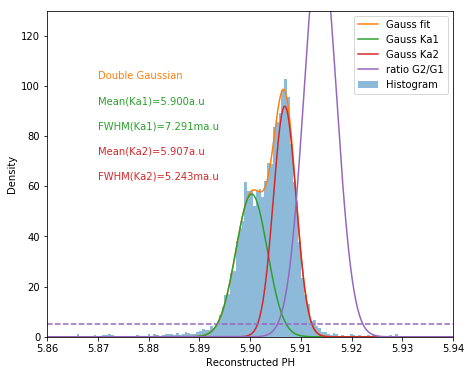

Ka2 PHs in [5.905,5.922] a.u.
PHmin= 5.905385758222846 PHmax= 5.922236772519787


In [35]:
nbinsKas = 200

# select data in Kas range (otherwise there is always a smaller pulse comimg from multiple-pulse rows)
print(min(dataKas_HR.SIGNAL), max(dataKas_HR.SIGNAL))
dataKas_HR = dataKas_HR[(dataKas_HR.SIGNAL>5.80) & (dataKas_HR.SIGNAL<5.95)]
print(min(dataKas_HR.SIGNAL), max(dataKas_HR.SIGNAL))
(PHmin,PHmax) = fit2GaussAndRatio(data=dataKas_HR.SIGNAL, a1=60, a2=120, mean1=5.89, mean2=5.905, sig1=0.005, sig2=0.005, 
                            nbins1=nbinsKas, xlab="Reconstructed PH")
print("PHmin=",PHmin, "PHmax=", PHmax)

#### 2.2.3 Select PH_ID of (non)Ka2 pulses

In [36]:

#select PH_IDs for Ka2 (in [PHmin,PHmax] interval)
dataKa2 = dataKas_HR[(dataKas_HR.SIGNAL >= PHmin) & (dataKas.SIGNAL <= PHmax)]

PH_ID_Ka2 = dataKa2.PH_ID.to_list()
PH_ID_Ka2_single = set(PH_ID_Ka2).intersection(dataKas_single_PH_ID) # good Ka2 pulses

#select PH_IDs to exclude Ka2 in single-pulse records
PH_ID_noKa2 = list(set(dataKas.PH_ID.to_list()).difference(PH_ID_Ka2_single))
print("Number of non-Ka2-single pulses:", len(PH_ID_noKa2))

Number of non-Ka2-single pulses: 7496


/home/ceballos/sw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


#### 2.2.4 Extract Ka2 pulses to build a new library

In [37]:
run = False
if run:
    tmpFile = resDir + "/" + "pp" + str(int(datetime.timestamp(datetime.now()))) + ".fits"
    nphs = len(PH_ID_noKa2)
    # first iteration
    expr = "'PH_ID != " + str(PH_ID_noKa2[0]) + "'"
    comm = ("fselect infile=" + fileph_Kas + "+8 outfile=" + fileph_Ka2 + " clobber=yes expr=" + expr)
    try:
        print("Selecting Ka2 pulses")
        print(comm)
        args = shlex.split(comm)
        #check_call(args, stderr=STDOUT)
    except:
        print("Error Selecting Ka2 pulses with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise
    # other non-selections follow
    iph = 1
    while iph < nphs:
        expr = "'"
        iiph = 1
        while (iiph < 20 and iph < nphs-1):
            expr = expr + "PH_ID != " + str(PH_ID_noKa2[iph]) + " && "
            iiph += 1
            iph  += 1

        expr = expr + "PH_ID != " + str(PH_ID_noKa2[iph]) + "'"
        iph += 1
        comm = ("fselect infile=" + fileph_Ka2 + "+8 outfile=" + tmpFile + " clobber=yes expr=" + expr)
        try:
            print("Selecting Ka2 pulses")
            print("iph=" + str(iph) + "/" + str(nphs))
            print(comm)
            args = shlex.split(comm)
            #check_call(args, stderr=STDOUT)
        except RuntimeError:
            print("Error Selecting Ka2 pulses with command:\n", comm)
            shutil.rmtree(tmpDir)
            raise

        shutil.copy(tmpFile, fileph_Ka2)
        os.remove(tmpFile)
        
    print("Finshed selection of Ka2 events")
    #raise SystemExit("Stop after selection of Ka2")

### 2.3 Build the new library of Ka2 pulses

In [38]:
run = False
if run:
    tmpFile = resDir + "/" + "pp" + str(int(datetime.timestamp(datetime.now()))) + ".fits"
    comm = ("tesreconstruction Recordfile=" + fileph_Ka2 + " TesEventFile=" + tmpFile + " Rcmethod='SIRENA'" +
            " PulseLength=" + str(plen) + " LibraryFile=" + libKa2 + " scaleFactor=0 samplesUp=" + str(sU) +
            " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=0 OFLib=yes FilterDomain=F " + 
            " detectionMode=STC detectSP=1 FilterMethod=" + F0orB0 + " clobber=yes EventListSize=1000" + 
            " EnergyMethod=" + method + " LagsOrNot=1 tstartPulse1=0 tstartPulse2=0 OFNoise=NSD " + 
            " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
            " filtEeV=" + str(Ka2eV) + " OFStrategy=FIXED OFLength=" + str(oflen) + " NoiseFile=" + noisefile +
            " monoenergy=" + str(Ka2eV) + " preBuffer=" + str(preBuffer))
    try:
        print("Building initial library (Kas)")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Building initial library (Kas) with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise
    os.remove(tmpFile)

## 3. Reconstruct all pulses with new Ka2 library

In [39]:
run = False
if run:
    comm = ("tesreconstruction Recordfile=" + fileph + " TesEventFile=" + evt_libKa2 + " Rcmethod='SIRENA'" +
            " PulseLength=" + str(plen) + " LibraryFile=" + libKa2 + " scaleFactor=0 samplesUp=" + str(sU) +
            " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=1 OFLib=yes FilterDomain=F detectionMode=STC" +
            " detectSP=1 FilterMethod=F0 clobber=yes EnergyMethod=" + method + " LagsOrNot=1 " +
            " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
            " filtEeV=" + str(Ka2eV) + " OFStrategy=FIXED OFLength=" + str(oflen) + " preBuffer=" + str(preBuffer))
    try:
        print("Reconstructing real data w/ library (Ka2)")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Reconstructing real data w/ initial library (Ka2) with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

    # Select only HR events
    comm = ("fselect  infile=" + evt_libKa2 + " outfile=" + evt_libKa2_HR + " expr='GRADE1 == " + str(plen) + 
           " && GRADE2 == " + str(plen) + "'")
    try:
        print("Selecting HR evts")
        print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Selecting HR Kas & Kb evts with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

## 4. Calibrate data fitting 2 Gaussians

### 4.1 Read HR pulses

In [79]:
colname = "'SIGNAL, PH_ID, GRADE1, GRADE2, PHI, LAGS, BSLN'" 
comm = ("fdump wrap=yes infile=" + evt_libKa2_HR + "+1 columns=" + colname + " rows='-' prhead=no " +
        "showcol=yes showunit=no showrow=no outfile=pulse.txt clobber=yes pagewidth=256")
try:
    print("FDUMPing evt file")
    #print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error FDUMPing evt file with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
data_HR = pandas.read_csv("pulse.txt", skiprows=0,sep="\s+")
os.remove("pulse.txt")
print("Number of initial (all energies) HR pulses:", len(data_HR)) 
#print(data_HR)


FDUMPing evt file
Number of initial (all energies) HR pulses: 13758


### 4.2 Fit 2 gaussians to Kas and 1 gaussian to Kb

Missing 1 records due to unusual baseline(< 100000.0 )
Missing 1 records due to unusual baseline(< 100000.0 )
100701
Message (Kas)= The relative error between two consecutive iterates is at most 0.000000
Param_cov (Kas)= [[ 8.20605315e-01  7.32467960e-05  2.28526954e-05 -3.56229673e-01
   3.18868631e-05 -2.91028514e-05]
 [ 7.32467960e-05  1.69621867e-08  9.28695858e-09 -1.28244165e-04
   6.64529147e-09 -5.26684360e-09]
 [ 2.28526954e-05  9.28695858e-09  7.92083547e-09 -9.48532036e-05
   4.01944994e-09 -2.96709116e-09]
 [-3.56229673e-01 -1.28244165e-04 -9.48532036e-05  1.81408892e+00
  -4.96085102e-05  2.94717025e-05]
 [ 3.18868631e-05  6.64529147e-09  4.01944994e-09 -4.96085102e-05
   3.22735339e-09 -2.24835228e-09]
 [-2.91028514e-05 -5.26684360e-09 -2.96709116e-09  2.94717025e-05
  -2.24835228e-09  2.23960419e-09]]
Message (Kb)= Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  mo

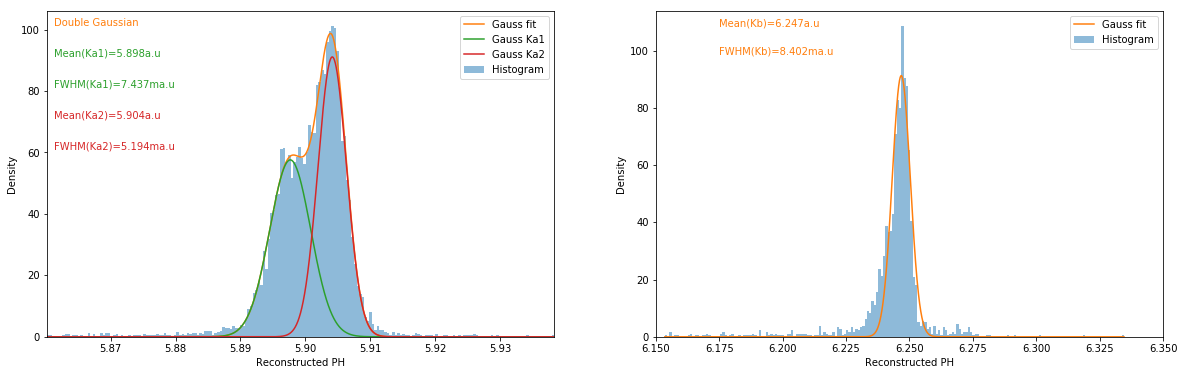

In [86]:
nbinsKas = 200
nbinsKb = 200
minBSLN = 1e5

# select data in Kas range (otherwise there is always a smaller pulse comimg from multiple rows)
dataKas_HR = data_HR[(data_HR.SIGNAL>5.86) & (data_HR.SIGNAL<5.94)]
len1 = len(dataKas_HR)
dataKas_HR = dataKas_HR[dataKas_HR.BSLN>minBSLN]
len2 = len(dataKas_HR)
print("Missing",(len1-len2), "records due to unusual baseline(<", minBSLN,")")

# select data in Kb range
dataKb_HR = data_HR[(data_HR.SIGNAL>6.15) & (data_HR.SIGNAL<6.35)]
len1 = len(dataKb_HR)
dataKb_HR = dataKb_HR[dataKb_HR.BSLN>minBSLN]
len2 = len(dataKb_HR)
print("Missing",(len1-len2), "records due to unusual baseline(<", minBSLN,")")
print(min(dataKb_HR.BSLN))

# Fit Gaussians and plot results
(mean1, mean2, mean3) = fit3gauss2hist(data1=dataKas_HR.SIGNAL, data2=dataKb_HR.SIGNAL, a1=56, a2=90, a3=90, mean1=5.89, mean2=5.90, mean3=6.25, 
                   sig1=0.005, sig2=0.005, sig3=0.005, nbins1=nbinsKas, nbins2=nbinsKb)


### 4.3 Create gain scale

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept     
    ------------------ ------------------
    1.7270981052583076 -4.298341546590408
Residuals= [2.90524196e-10]
Params= [ 1.72709811 -4.29834155]
RMSE: 9.840802752335193e-06
R-squared: 0.9999999987786258


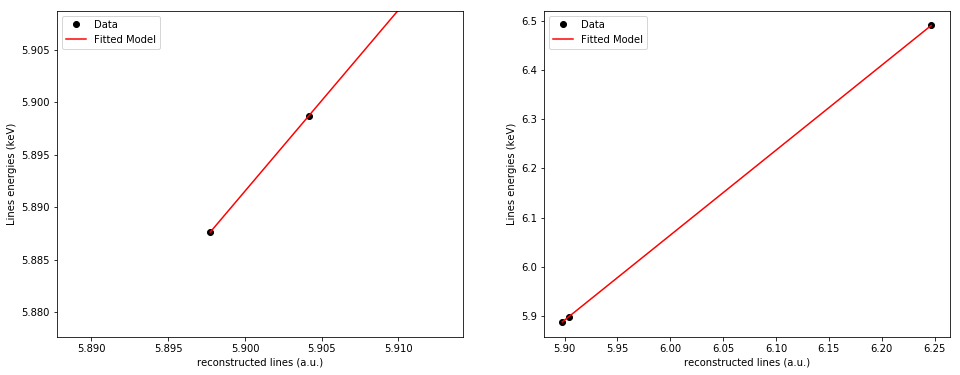

In [42]:
lines = (Ka1keV, Ka2keV, KbkeV)
recon_lines = (mean1,mean2,mean3)
(slope, inter) = gainScaleFit(xData=recon_lines, yData=lines)

### 4.4 Calibrate energies

Text(0,0.5,'Density')

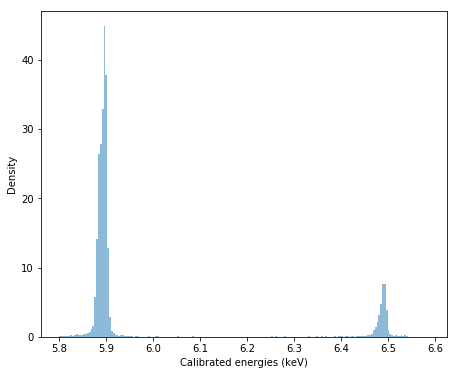

In [43]:
eners_HR = inter + slope * data_HR.SIGNAL
# select data in Kas/Kb range (otherwise there is always a smaller pulse comimg from multiple rows)
enerKs_HR = eners_HR[(eners_HR > 5.80) & (eners_HR < 6.6)]

# create histogram
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1, 2, 1)
bin_heights, bin_borders, _ = ax1.hist(enerKs_HR,bins=200, density=True,label="Histogram", alpha=0.5)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
ax1.set_xlabel("Calibrated energies (keV)")
ax1.set_ylabel("Density")


## 5. Get FWHM of Kas lines fitting Voigt profiles

Message (Kas)= Number of calls to function has reached maxfev = 100.
Message (Kb)= Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000


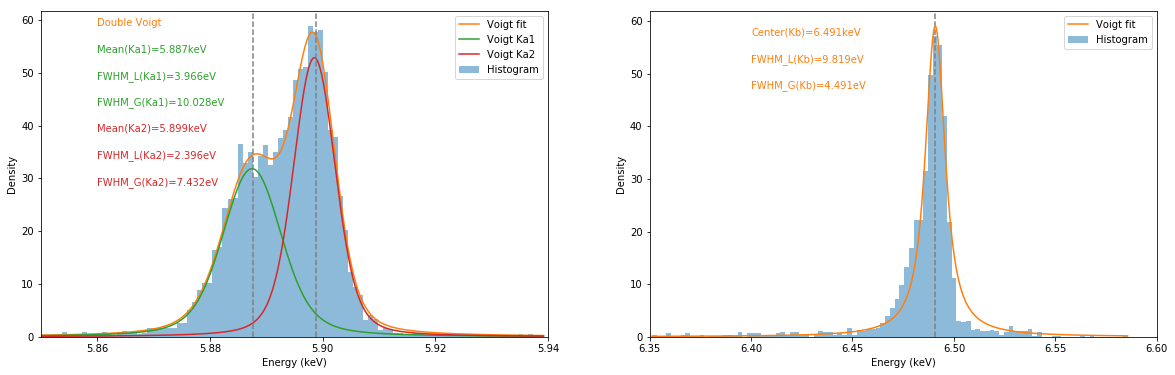

In [44]:
nbinsKas = 100
nbinsKb = 100
# select data in Kas/Kb range (otherwise there is always a smaller pulse comimg from multiple rows)
enerKas_HR = eners_HR[(eners_HR > 5.85) & (eners_HR < 5.94)]
#enerKas_HR.to_csv(resDir + "/enerKas_HR.hist", header=None, index=False )
enerKb_HR = eners_HR[(eners_HR>6.35) & (eners_HR<6.6)]

fit3Voigt2hist(data1=enerKas_HR, data2=enerKb_HR, a1=30, a2=60, a3=60, x0_1=Ka1keV, x0_2=Ka2keV, x0_3=KbkeV, 
                   fwhm_L1=0.005, fwhm_L2=0.005, fwhm_L3=0.005, fwhm_G1=0.002, fwhm_G2=0.002, 
                   fwhm_G3=0.002, nbins1=nbinsKas, nbins2=nbinsKb)

## 6. Jitter correction

### 6.1 Plot Pulse Height vs PHASE (distance between trigger and parabola fit = PHI + LAGS) & fit polynomial

Fit Kas= 5.902+ (-0.000)*x+(-0.017)*x²
Fit Kas (corrected)= 5.902+ (-0.000)*x+(-0.000)*x²
acabo
Fit Kas= 6.245+ (-0.002)*x+(-0.020)*x²
Fit Kas (corrected)= 6.245+ (-0.000)*x+(0.000)*x²
acabo


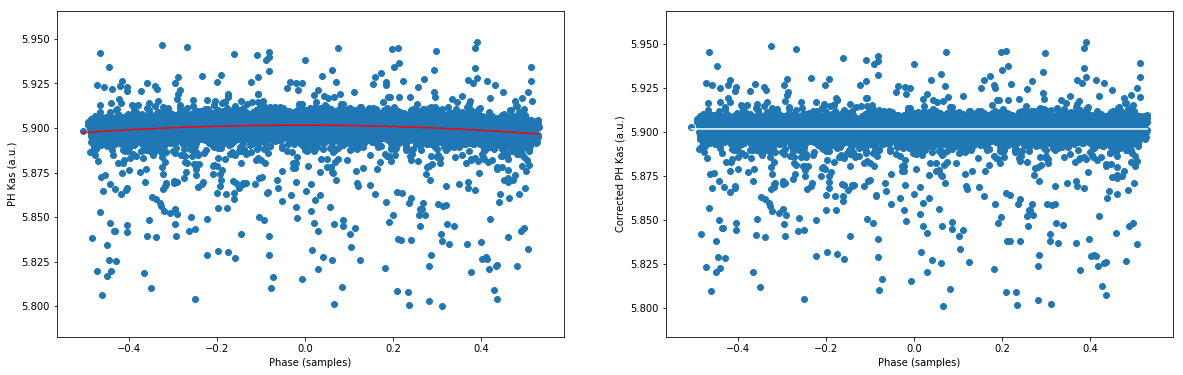

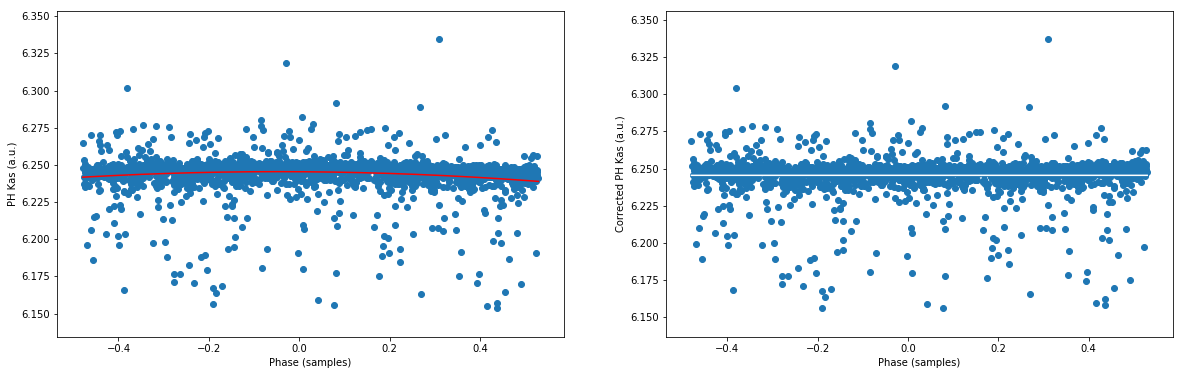

In [45]:
# FROM ABOVE:
#dataKas_HR = data_HR[(data_HR.SIGNAL>5.80) & (data_HR.SIGNAL<5.95) & (data_HR.BSLN>50000)]
#dataKb_HR = data_HR[(data_HR.SIGNAL>6.15) & (data_HR.SIGNAL<6.35) & (data_HR.BSLN>50000)]

phaseKas_HR = dataKas_HR.PHI + dataKas_HR.LAGS
phaseKb_HR = dataKb_HR.PHI + dataKb_HR.LAGS
#print(len(phaseKas_HR))

dataKas_HR_jitter = jitterCorr(reconPH=dataKas_HR.SIGNAL, phase=phaseKas_HR)
dataKb_HR_jitter = jitterCorr(reconPH=dataKb_HR.SIGNAL, phase=phaseKb_HR)


### 6.2 Fit gaussians, create new Gain scale and re-calibrate energies

Message (Kas)= The relative error between two consecutive iterates is at most 0.000000
Message (Kb)= The relative error between two consecutive iterates is at most 0.000000


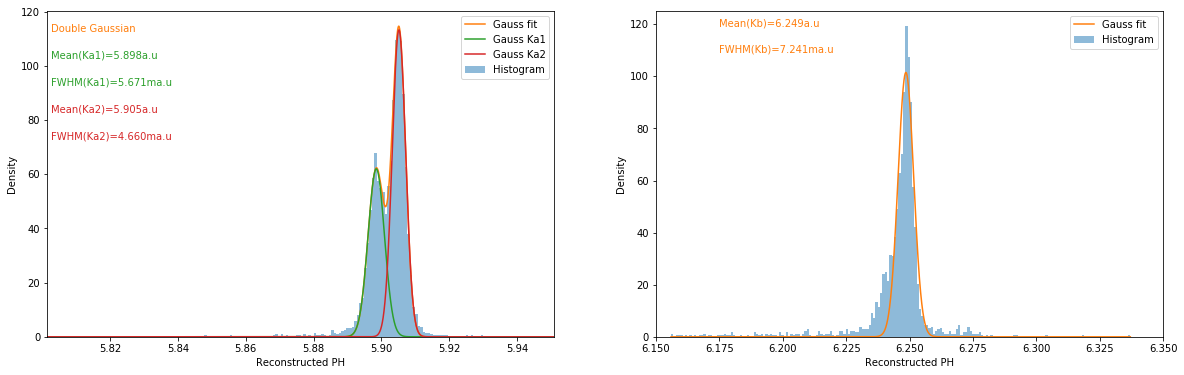

In [46]:
nbinsKas = 200
nbinsKb = 200

(mean1j, mean2j, mean3j) = fit3gauss2hist(data1=dataKas_HR_jitter, data2=dataKb_HR_jitter, a1=56, a2=110, a3=100, 
                                       mean1=5.895, mean2=5.905, mean3=6.25, sig1=0.005, sig2=0.005, sig3=0.005,
                                       nbins1=nbinsKas, nbins2=nbinsKb, plot=True)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept     
    ------------------ ------------------
    1.7225814097965293 -4.273190528804949
Residuals= [8.45623756e-08]
Params= [ 1.72258141 -4.27319053]
RMSE: 0.0001678912104119044
R-squared: 0.9999996444967094


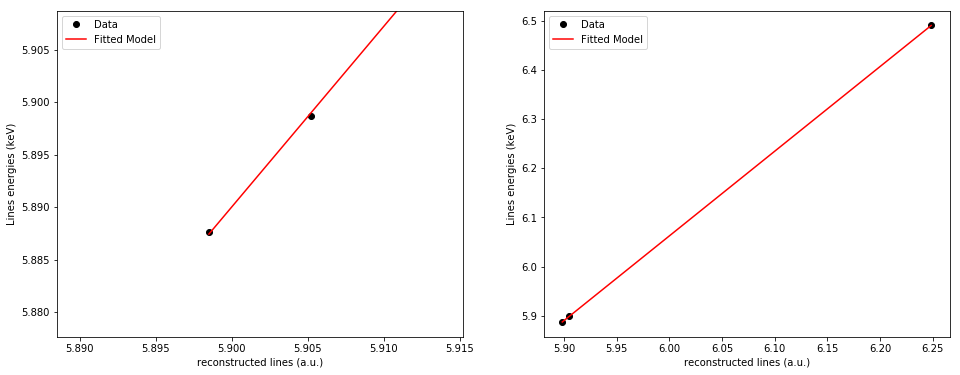

In [47]:
# create gain scale
recon_lines = (mean1j,mean2j,mean3j)
(slope, inter) = gainScaleFit(xData=recon_lines, yData=lines)

In [48]:
# recalibrate energies
enerKas_HR_jitter = inter + slope * dataKas_HR_jitter
enerKb_HR_jitter = inter + slope * dataKb_HR_jitter
print(min(enerKas_HR_jitter), max(enerKas_HR_jitter))

5.720218312684547 5.9780013671036345


### 6.3 Fit histogram of jitter-corrected energies

Message (Kas)= Number of calls to function has reached maxfev = 100.
Message (Kb)= The relative error between two consecutive iterates is at most 0.000000


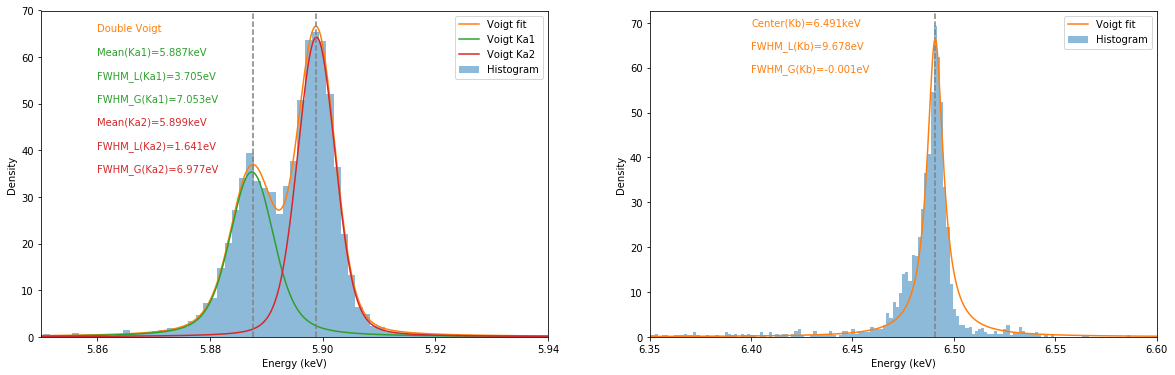

In [49]:
nbinsKas = 200
nbinsKb = 200

fit3Voigt2hist(data1=enerKas_HR_jitter, data2=enerKb_HR_jitter, a1=40, a2=70, a3=60,
               x0_1=Ka1keV, x0_2=Ka2keV, x0_3=KbkeV, fwhm_L1=0.005, fwhm_L2=0.005, fwhm_L3=0.005, 
               fwhm_G1=0.0001, fwhm_G2=0.0001, fwhm_G3=0.001, nbins1=nbinsKas, nbins2=nbinsKb)


## 7. baseline drift correction

### 7.1 Plot jiterr_recon PH vs Baseline & Fit polynomial


100701
Fit Kas= 5.863+ (0.000)*x+(-0.000)*x²
Fit Kas (corrected)= 5.863+ (0.000)*x+(-0.000)*x²
Fit Kb= 6.241+ (0.000)*x+(-0.000)*x²
Fit Kb (corrected)= 6.241+ (-0.000)*x+(0.000)*x²


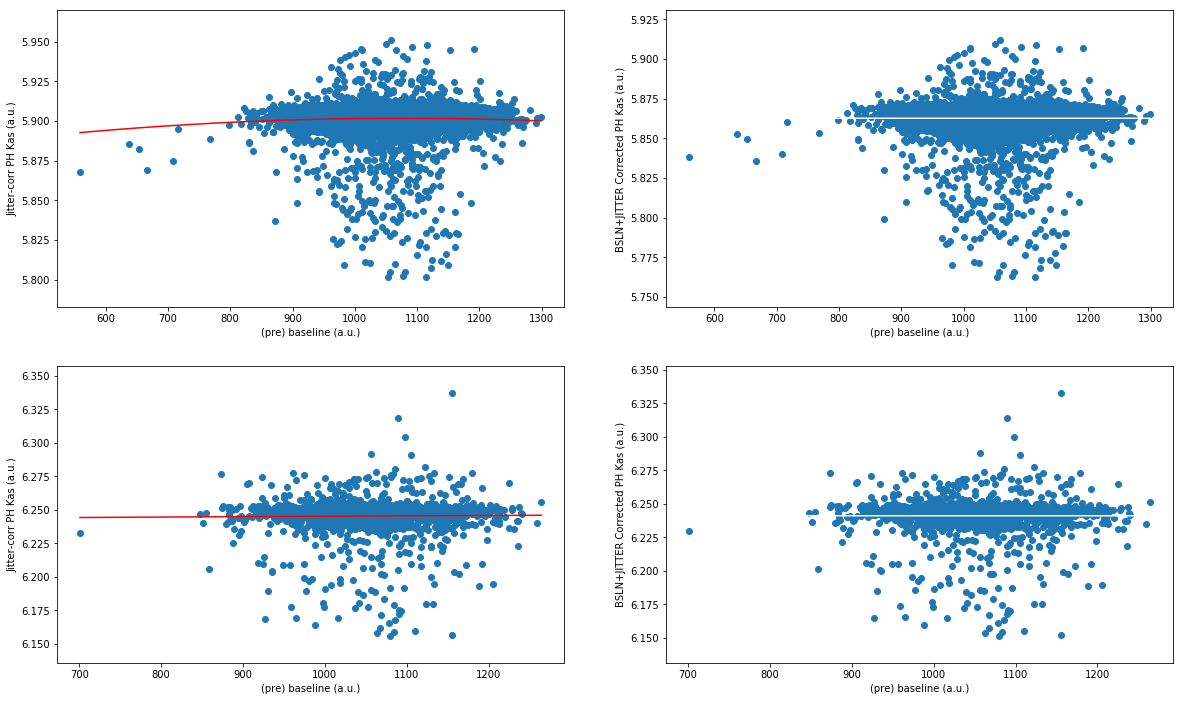

In [50]:
baseKas_HR = dataKas_HR.BSLN - 1e5
baseKb_HR = dataKb_HR.BSLN - 1e5
print(min(dataKb_HR.BSLN))

######## Kas ####################
# plot baselines
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(baseKas_HR, dataKas_HR_jitter, marker="o")
# fit polynomial
x_interval_for_fit = np.linspace(min(baseKas_HR), max(baseKas_HR), 10000)
coefs = poly.polyfit(x=baseKas_HR, y=dataKas_HR_jitter, deg=2) 
#print(coefs)
ffit = poly.polyval(x_interval_for_fit, coefs)
ax1.plot(x_interval_for_fit, ffit,'-', color="red")
ax1.set_xlabel("(pre) baseline (a.u.)")
ax1.set_ylabel("Jitter-corr PH Kas (a.u.)")
print("Fit Kas=",'{:0.3f}'.format(coefs[0]) + "+ (" + '{:0.3f}'.format(coefs[1]) + ")*x" + "+(" + '{:0.3f}'.format(coefs[2]) + ")*x²" )
# subtract polynomial (flat baseline effect)
ax2 = fig.add_subplot(2, 2, 2)
dataKas_HR_jitter_bsln = dataKas_HR_jitter - coefs[1]*baseKas_HR - coefs[2]*baseKas_HR**2
ax2.scatter(baseKas_HR, dataKas_HR_jitter_bsln, marker="o")
ax2.set_xlabel("(pre) baseline (a.u.)")
ax2.set_ylabel("BSLN+JITTER Corrected PH Kas (a.u.)")
coefsB = poly.polyfit(x=baseKas_HR, y=dataKas_HR_jitter_bsln, deg=2)
print("Fit Kas (corrected)=",'{:0.3f}'.format(coefsB[0]) + "+ (" + '{:0.3f}'.format(coefsB[1]) + ")*x" + "+(" + '{:0.3f}'.format(coefsB[2]) + ")*x²" )
ffitB = poly.polyval(x_interval_for_fit, coefsB)
ax2.plot(x_interval_for_fit, ffitB,'-', color="white")

######## Kb ####################
# plot baselines
ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(baseKb_HR, dataKb_HR_jitter, marker="o")
# fit polynomial
x_interval_for_fit = np.linspace(min(baseKb_HR), max(baseKb_HR), 10000)
coefs = poly.polyfit(x=baseKb_HR, y=dataKb_HR_jitter, deg=2) # recommended instead of np.polyfit + np.poly1d
ffit = poly.polyval(x_interval_for_fit, coefs)
ax3.plot(x_interval_for_fit, ffit,'-', color="red")
ax3.set_xlabel("(pre) baseline (a.u.)")
ax3.set_ylabel("Jitter-corr PH Kas (a.u.)")
print("Fit Kb=",'{:0.3f}'.format(coefs[0]) + "+ (" + '{:0.3f}'.format(coefs[1]) + ")*x" + "+(" + '{:0.3f}'.format(coefs[2]) + ")*x²" )
# subtract polynomial (flat jitter effect)
ax4 = fig.add_subplot(2, 2, 4)
dataKb_HR_jitter_bsln = dataKb_HR_jitter - coefs[1]*baseKb_HR - coefs[2]*baseKb_HR**2
ax4.scatter(baseKb_HR, dataKb_HR_jitter_bsln, marker="o")
ax4.set_xlabel("(pre) baseline (a.u.)")
ax4.set_ylabel("BSLN+JITTER Corrected PH Kas (a.u.)")
coefsB = poly.polyfit(x=baseKb_HR, y=dataKb_HR_jitter_bsln, deg=2)
print("Fit Kb (corrected)=",'{:0.3f}'.format(coefsB[0]) + "+ (" + '{:0.3f}'.format(coefsB[1]) + ")*x" + "+(" + '{:0.3f}'.format(coefsB[2]) + ")*x²" )
ffitB = poly.polyval(x_interval_for_fit, coefsB)
ax4.plot(x_interval_for_fit, ffitB,'-', color="white")

### 7.2 Fit gaussians, create new Gain scale and re-calibrate energies

Message (Kas)= The relative error between two consecutive iterates is at most 0.000000
Message (Kb)= The relative error between two consecutive iterates is at most 0.000000


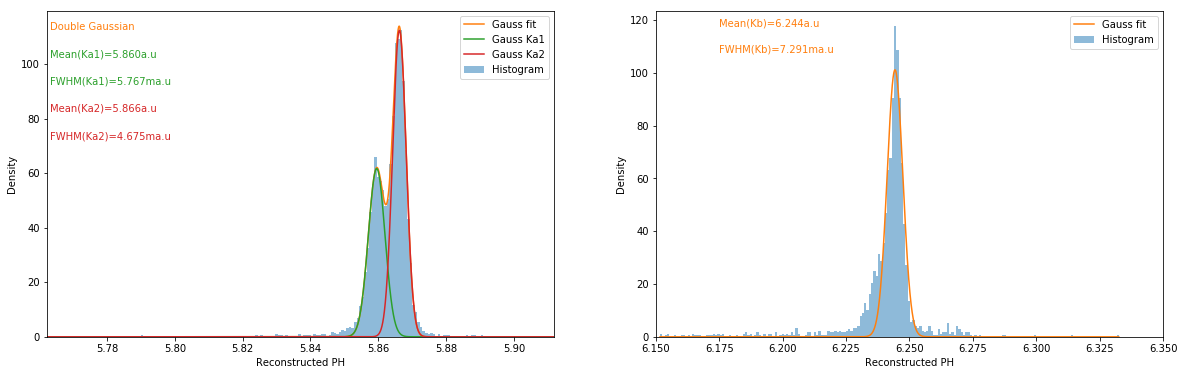

In [51]:
nbinsKas = 200
nbinsKb = 200

(mean1bsln, mean2bsln, mean3bsln) = fit3gauss2hist(data1=dataKas_HR_jitter_bsln, data2=dataKb_HR_jitter_bsln, 
                                                   a1=60, a2=120, a3=110, mean1=5.86, mean2=5.87, mean3=6.24,
                                                   sig1=0.005, sig2=0.005, sig3=0.005, nbins1=nbinsKas, nbins2=nbinsKb, plot=True)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept     
    ------------------ ------------------
    1.5658726519011454 -3.287334176977956
Residuals= [1.89487136e-07]
Params= [ 1.56587265 -3.28733418]
RMSE: 0.00025132126552631604
R-squared: 0.9999992033892176


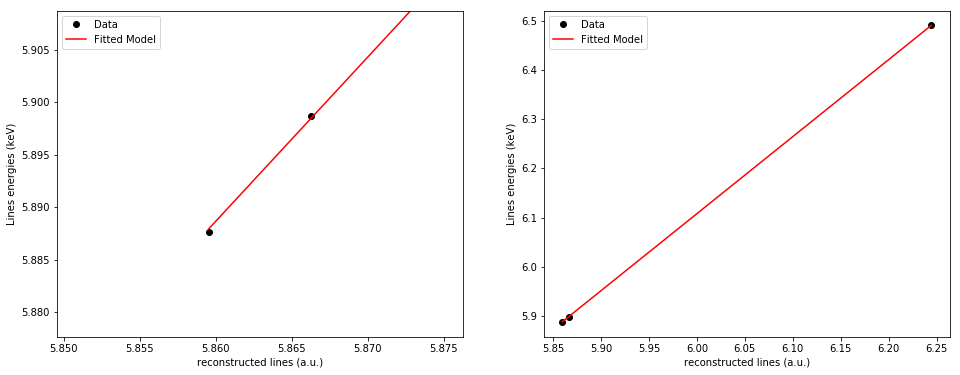

In [52]:
# create gain scale
recon_lines = (mean1bsln,mean2bsln,mean3bsln)
(slope, inter) = gainScaleFit(xData=recon_lines, yData=lines)


In [53]:
# recalibrate energies
#enerKas_HR_jitter_bsln = coefs[0] + coefs[1] * dataKas_HR_jitter_bsln + coefs[2] * dataKas_HR_jitter_bsln**2
#enerKb_HR_jitter_bsln = coefs[0] + coefs[1] * dataKb_HR_jitter_bsln + coefs[2] * dataKb_HR_jitter_bsln**2
enerKas_HR_jitter_bsln = inter + slope * dataKas_HR_jitter_bsln
enerKb_HR_jitter_bsln = inter + slope * dataKb_HR_jitter_bsln

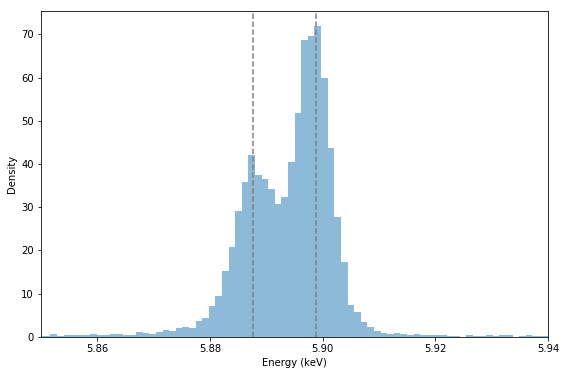

In [54]:
nbinsKas = 200
nbinsKb = 200
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1, 2, 1)

# create histogram
bin_heights, bin_borders, _ = ax1.hist(enerKas_HR_jitter_bsln,bins=nbinsKas, density=True,label="Histogram", alpha=0.5)
ax1.set_xlim(5.85, 5.94)
ax1.set_xlabel("Energy (keV)")
ax1.set_ylabel("Density")
ax1.axvline(Ka1keV,linestyle='--', color='gray')
ax1.axvline(Ka2keV,linestyle='--', color='gray')


### 7.3 Fit histogram of baseline-jitter-corrected energies

Message (Kas)= Number of calls to function has reached maxfev = 100.
Message (Kb)= The relative error between two consecutive iterates is at most 0.000000


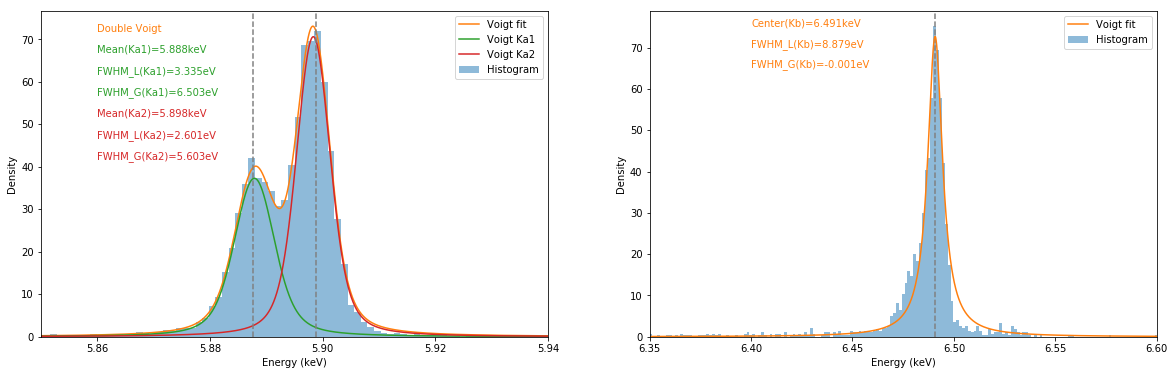

In [55]:
nbinsKas = 200
nbinsKb = 200

fit3Voigt2hist(data1=enerKas_HR_jitter_bsln, data2=enerKb_HR_jitter_bsln, a1=50, a2=85, a3=90,
               x0_1=Ka1keV, x0_2=Ka2keV, x0_3=KbkeV, fwhm_L1=0.005, fwhm_L2=0.005, fwhm_L3=0.005, 
               fwhm_G1=0.0001, fwhm_G2=0.0001, fwhm_G3=0.001, nbins1=nbinsKas, nbins2=nbinsKb)


## 8. Absolute value

### 8.1 Reconstruct pulses with Ka2 library and absolute values

In [56]:
run = False
if run:
    comm = ("tesreconstruction Recordfile=" + fileph + " TesEventFile=" + evt_libKa2_abs + " Rcmethod='SIRENA'" +
            " PulseLength=" + str(plen) + " LibraryFile=" + libKa2 + " scaleFactor=0 samplesUp=" + str(sU) +
            " nSgms=" + str(nS) + " samplesDown=" + str(sD) + " opmode=1 OFLib=yes FilterDomain=F detectionMode=STC" +
            " detectSP=1 FilterMethod=F0 clobber=yes EnergyMethod=" + method + " LagsOrNot=1 " +
            " XMLFile=${SIXTE}/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml" +
            " filtEeV=" + str(Ka2eV) + " OFStrategy=FIXED OFLength=" + str(oflen) + " preBuffer=" + str(preBuffer))
    try:
        print("Reconstructing real data w/ library (Ka2)")
        print(comm)
        args = shlex.split(comm)
        #check_call(args, stderr=STDOUT)
    except:
        print("Error Reconstructing real data w/ initial library (Ka2) with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

    # Select only HR events
    comm = ("fselect  infile=" + evt_libKa2_abs + " outfile=" + evt_libKa2_abs_HR + " expr='GRADE1 == " + str(plen) + 
           " && GRADE2 == " + str(plen) + "'")
    try:
        print("Selecting HR evts")
        #print(comm)
        args = shlex.split(comm)
        check_call(args, stderr=STDOUT)
    except:
        print("Error Selecting HR Kas & Kb evts with command:\n", comm)
        shutil.rmtree(tmpDir)
        raise

### 8.2 Read HR pulses

In [57]:
colname = "'SIGNAL, PH_ID, GRADE1, GRADE2, PHI, LAGS, BSLN'" 
comm = ("fdump wrap=yes infile=" + evt_libKa2_abs_HR + "+1 columns=" + colname + " rows='-' prhead=no " +
        "showcol=yes showunit=no showrow=no outfile=pulse.txt clobber=yes pagewidth=256")
try:
    print("FDUMPing evt file")
    #print(comm)
    args = shlex.split(comm)
    check_call(args, stderr=STDOUT)
except:
    print("Error FDUMPing evt file with command:\n", comm)
    shutil.rmtree(tmpDir)
    raise
dataAbs_HR = pandas.read_csv("pulse.txt", skiprows=0,sep="\s+")
os.remove("pulse.txt")
print("Number of initial (all energies) HR pulses:", len(dataAbs_HR)) 
#print(dataAbs_HR)

FDUMPing evt file
Number of initial (all energies) HR pulses: 13758


### 8.3 Fit 2 gaussians to Kas and 1 gaussian to Kb

Missing 1 records due to unusual baseline(< 100000.0 )
Missing 1 records due to unusual baseline(< 100000.0 )
Min baseline= 100701
Message (Kas)= Number of calls to function has reached maxfev = 100.
Message (Kb)= The relative error between two consecutive iterates is at most 0.000000


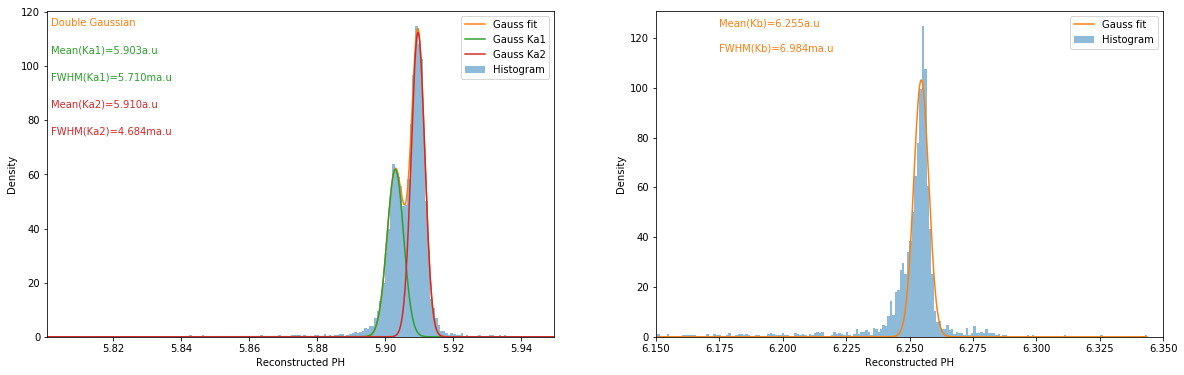

In [59]:
nbinsKas = 200
nbinsKb = 200
minBSLN = 1e5
# select data in Kas range (otherwise there is always a smaller pulse comimg from multiple rows)
dataKasAbs_HR = dataAbs_HR[(dataAbs_HR.SIGNAL>5.80) & (dataAbs_HR.SIGNAL<5.95)]
len1 = len(dataKasAbs_HR)
dataKasAbs_HR = dataKasAbs_HR[dataKasAbs_HR.BSLN>minBSLN]
len2 = len(dataKasAbs_HR)
print("Missing",(len1-len2), "records due to unusual baseline(<", minBSLN,")")

# select data in Kb range
dataKbAbs_HR = dataAbs_HR[(dataAbs_HR.SIGNAL>6.15) & (dataAbs_HR.SIGNAL<6.35)]
len1 = len(dataKbAbs_HR)
dataKbAbs_HR = dataKbAbs_HR[dataKbAbs_HR.BSLN>minBSLN]
len2 = len(dataKbAbs_HR)
print("Missing",(len1-len2), "records due to unusual baseline(<", minBSLN,")")
print("Min baseline=",min(dataKbAbs_HR.BSLN))

# Fit Gaussians and plot results
(mean1abs, mean2abs,mean3abs) = fit3gauss2hist(data1=dataKasAbs_HR.SIGNAL, data2=dataKbAbs_HR.SIGNAL, 
                                               a1=56, a2=110, a3=100, mean1=5.89, mean2=5.90, mean3=6.25, 
                                               sig1=0.005, sig2=0.005, sig3=0.005, 
                                               nbins1=nbinsKas, nbins2=nbinsKb, plot=True)


### 8.4 Create gain scale

In [60]:
lines = (Ka1keV, Ka2keV, KbkeV)
recon_lines = (mean1abs,mean2abs,mean3abs)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept     
    ------------------ ------------------
    1.7150274981107771 -4.236384580152966
Residuals= [5.20497303e-08]
Params= [ 1.7150275  -4.23638458]
RMSE: 0.00013171905748815945
R-squared: 0.999999781181048


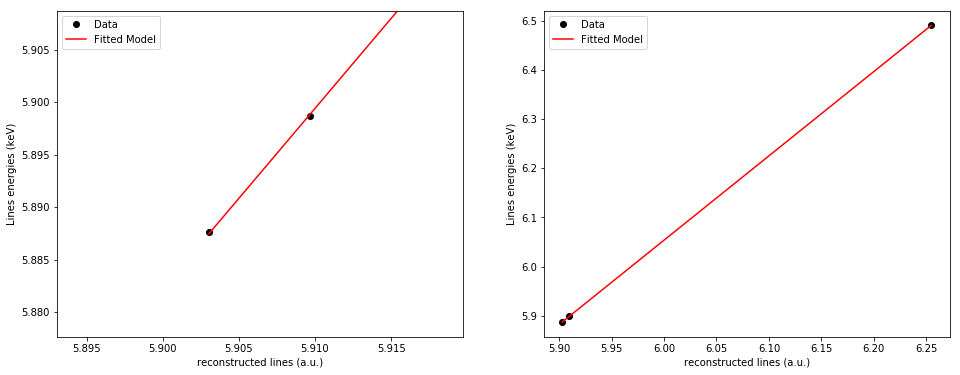

In [61]:
# gain scale
(slopeAbs, interAbs) = gainScaleFit(xData=recon_lines, yData=lines)

### 8.5 Calibrate energies

Text(0,0.5,'Density')

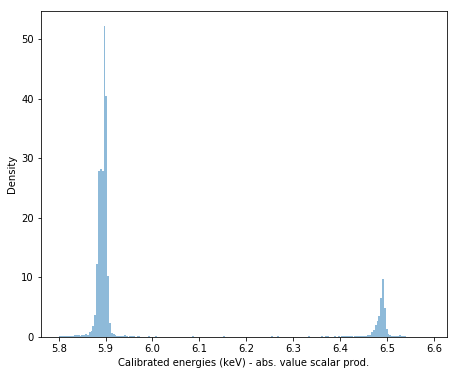

In [62]:
enersAbs_HR = interAbs + slopeAbs * dataAbs_HR.SIGNAL
# select data in Kas/Kb range (otherwise there is always a smaller pulse comimg from multiple rows)
enerKsAbs_HR = enersAbs_HR[(enersAbs_HR > 5.80) & (enersAbs_HR < 6.6)]

# create histogram
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1, 2, 1)
bin_heights, bin_borders, _ = ax1.hist(enerKsAbs_HR,bins=200, density=True,label="Histogram", alpha=0.5)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
ax1.set_xlabel("Calibrated energies (keV) - abs. value scalar prod.")
ax1.set_ylabel("Density")


### 8.6. Get FWHM of Kas lines fitting Voigt profiles

Message (Kas)= Number of calls to function has reached maxfev = 100.
Message (Kb)= The relative error between two consecutive iterates is at most 0.000000


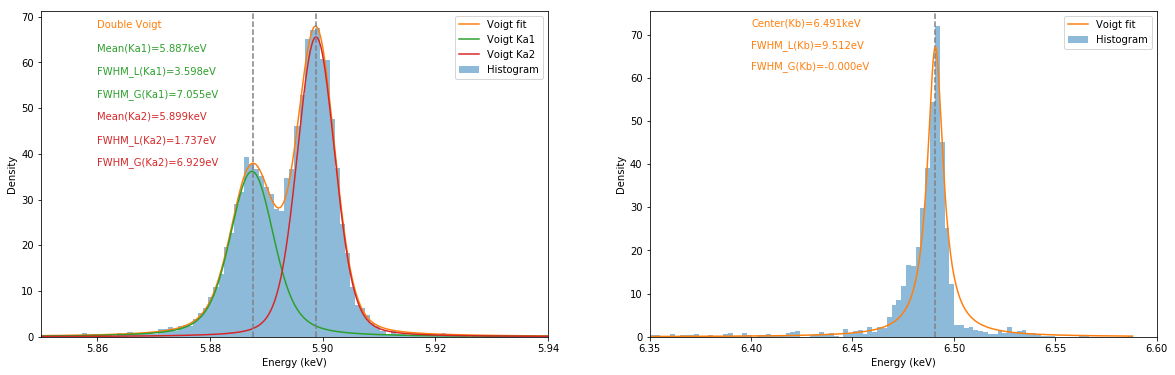

In [63]:
nbinsKas = 100
nbinsKb = 100
enerKasAbs_HR = enersAbs_HR[(enersAbs_HR > 5.85) & (enersAbs_HR < 5.94)]
#enerKasAbs_HR.to_csv(resDir + "/enerKasAbs_HR.hist", header=None, index=False )
enerKbAbs_HR = enersAbs_HR[(enersAbs_HR>6.35) & (enersAbs_HR<6.6)]

fit3Voigt2hist(data1=enerKasAbs_HR, data2=enerKbAbs_HR, a1=50, a2=70, a3=50,
               x0_1=Ka1keV, x0_2=Ka2keV, x0_3=KbkeV, fwhm_L1=0.005, fwhm_L2=0.005, fwhm_L3=0.005, 
               fwhm_G1=0.0001, fwhm_G2=0.0001, fwhm_G3=0.001, nbins1=nbinsKas, nbins2=nbinsKb)
